In [1]:
def print_section(text):
    print('##############################################')
    print('###  ', text)
    print('##############################################')


print_section('Start imports')

import os
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent.parent)))

import tqdm
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
import matplotlib.axes as am
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.decomposition
import sklearn.cluster
import sklearn.model_selection

%matplotlib widget

from src.particle_funcs import distance_matrix as distance_matrix
from src.particle_funcs import io as particles_io
from src.leap_funcs.qubo import q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import parameterstudy

from src import h5py_funcs
from src.h5py_funcs import inspections, discoveries, init_custom_getstates, io, parameterstudy_using_info_file

print_section('Finished imports')
#%%

##############################################
###   Start imports
##############################################


no cupy available, imported numpy as usual
Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.
##############################################
###   Finished imports
##############################################


In [2]:
import io
print('io.DEFAULT_BUFFER_SIZE', io.DEFAULT_BUFFER_SIZE)

io.DEFAULT_BUFFER_SIZE 8192


In [3]:
print_section('Define read from/write to params - Start')
#read_from = ['sample_data', 'pickle']
#write_to = ['pickle', 'None']
read_from = 'pickle'
#write_to = 'pickle'
print('  read_from:', read_from, ' , possibilities: \'sample_data\', \'pickle\'')
#print('  write_to:', write_to, ' , possibilities: \'pickle\', \'None\'')
print_section('Define read from/write to params - Finished')

##############################################
###   Define read from/write to params - Start
##############################################
  read_from: pickle  , possibilities: 'sample_data', 'pickle'
##############################################
###   Define read from/write to params - Finished
##############################################


In [4]:
if read_from == 'pickle':
   print_section('Read from pickle - Start')
   with open(pathlib.Path('../01_out',f'df_7_1.df'), 'rb') as f:
       df = pickle.load(f)
   print_section('Read from pickle - Finished')

##############################################
###   Read from pickle - Start
##############################################
##############################################
###   Read from pickle - Finished
##############################################


In [5]:
print(df.columns)

Index(['identifiers', 'annealing_time', 'annealing_time_log10',
       'programming_thermalization', 'programming_thermalization_log10',
       'readout_thermalization', 'readout_thermalization_log10',
       'flux_drift_compensation', 'chain_strength', 'anneal_offsets_1_qubits',
       'anneal_offsets_2_qubits', 'anneal_offsets_3_qubits', 't00', 't01',
       't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09', 't10', 't11',
       's00', 's01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 'estimated_runtime', 'is_found_best',
       'num_runs_is_found_best', 'num_samples_is_found_best',
       'num_samples_is_found_best_per_run', 'is_found_best_per_run',
       'num_samples', 'num_runs', 'num_subs_per_run', 'num_samples_per_run',
       'num_samples_per_sub_per_run', 'num_matched', 'num_matched_per_run',
       'num_matched_per_sub_per_run', 'num_samples_matched',
       'num_samples_matched_per_run', 'num_samples_matched_per_sub_per_run',
       's

In [6]:
print(df.head().to_string())

     identifiers  annealing_time  annealing_time_log10  programming_thermalization  programming_thermalization_log10  readout_thermalization  readout_thermalization_log10  flux_drift_compensation  chain_strength  anneal_offsets_1_qubits  anneal_offsets_2_qubits  anneal_offsets_3_qubits  t00       t01       t02       t03       t04       t05       t06       t07       t08       t09       t10       t11  s00       s01       s02       s03       s04       s05       s06       s07       s08       s09       s10  s11  estimated_runtime  is_found_best  num_runs_is_found_best  num_samples_is_found_best num_samples_is_found_best_per_run                                         is_found_best_per_run  num_samples  num_runs                num_subs_per_run                                           num_samples_per_run                                                                                                                                                 num_samples_per_sub_per_run  num_matched      

In [ ]:
params = df.columns[0:37].drop(['t00', 't01', 't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09', 't10', 't11',\
                                's00', 's01',        's03', 's04',        's06', 's07',        's09', 's10'])
params = df.columns
params_to_drop = [\
       't00', 't01', 't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09', 't10', 't11',
       's00', 's01'       , 's03', 's04',        's06', 's07',        's09', 's10',
       'estimated_runtime', 'num_samples_is_found_best_per_run',
       'is_found_best_per_run', 'num_subs_per_run',
       'num_samples_per_run', 'num_samples_per_sub_per_run', 'num_matched_per_run', 'num_matched_per_sub_per_run',
       'num_samples_matched_per_run', 'submissions',
       'num_samples_matched_per_sub_per_run', 'fraction_samples_is_found_best_per_run'\
]
params_to_scale = [\
       'annealing_time', 'annealing_time_log10', 'programming_thermalization','programming_thermalization_log10',
       'readout_thermalization','readout_thermalization_log10', 'flux_drift_compensation', 'chain_strength',
       'anneal_offsets_1_qubits', 'anneal_offsets_2_qubits',
       'anneal_offsets_3_qubits',
       's00', 's01'       , 's03', 's04',        's06', 's07',        's09', 's10',
]

params = params.drop(params_to_drop)

In [8]:
param_ranges = [[p.min(), p.max()] for p in df[params.drop('identifiers')].values.T]
param_ranges

[[0.5524776656483985, 1978.316814603083],
 [-0.25768527398984453, 3.296295842274395],
 [14.472734183073044, 2499.3639974854887],
 [1.1605505856075429, 3.3978295096629005],
 [0.3569573163986206, 2490.0937592610717],
 [-0.4473837120693469, 3.3962156998520032],
 [0.0018564723432064056, 0.9984209444373846],
 [0.03482419066131115, 9.984666192904115],
 [-0.6471530140377582, 0.6462200978770852],
 [-0.6480047006160021, 0.6486023673787714],
 [-0.640754789672792, 0.647574162762612],
 [2.2332679847102186e-172, 1.0],
 [3.6809554396172053e-115, 1.0],
 [6.067087801917164e-58, 1.0],
 [1.0, 1.0],
 [False, True],
 [0, 10],
 [0, 49],
 [10000, 10000],
 [10, 10],
 [0, 149],
 [0, 149],
 [0.0, 1.0],
 [0.0, 0.0049]]

In [9]:
df_params_rescaled = df.copy()
print(df_params_rescaled.head().to_string())
df_params_rescaled[params_to_scale] = df[params_to_scale] / df[params_to_scale].max()
df_params_rescaled.fillna(0, inplace=True)
df_params_rescaled

     identifiers  annealing_time  annealing_time_log10  programming_thermalization  programming_thermalization_log10  readout_thermalization  readout_thermalization_log10  flux_drift_compensation  chain_strength  anneal_offsets_1_qubits  anneal_offsets_2_qubits  anneal_offsets_3_qubits  t00       t01       t02       t03       t04       t05       t06       t07       t08       t09       t10       t11  s00       s01       s02       s03       s04       s05       s06       s07       s08       s09       s10  s11  estimated_runtime  is_found_best  num_runs_is_found_best  num_samples_is_found_best num_samples_is_found_best_per_run                                         is_found_best_per_run  num_samples  num_runs                num_subs_per_run                                           num_samples_per_run                                                                                                                                                 num_samples_per_sub_per_run  num_matched      

,identifiers,annealing_time,annealing_time_log10,programming_thermalization,programming_thermalization_log10,readout_thermalization,readout_thermalization_log10,flux_drift_compensation,chain_strength,anneal_offsets_1_qubits,...,num_matched,num_matched_per_run,num_matched_per_sub_per_run,num_samples_matched,num_samples_matched_per_run,num_samples_matched_per_sub_per_run,submissions,fraction_runs_is_found_best,fraction_samples_is_found_best,fraction_samples_is_found_best_per_run
0,zz_8097006340,0.002321,0.662000,0.373088,2.969641,0.819494,3.309761,0.026055,0.320253,0.28778,...,85,"[9, 8, 9, 9, 9, 8, 9, 9, 9, 6]","[[3, 3, 3], [2, 3, 3], [3, 3, 3], [3, 3, 3], [...",85,"[9, 8, 9, 9, 9, 8, 9, 9, 9, 6]","[[3, 3, 3], [2, 3, 3], [3, 3, 3], [3, 3, 3], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0024,"[0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.0..."
1,zz_3271526003,0.002374,0.671799,0.373088,2.969641,0.819494,3.309761,0.026055,0.320253,0.28778,...,75,"[5, 8, 9, 8, 8, 7, 9, 7, 8, 6]","[[1, 3, 1], [3, 2, 3], [3, 3, 3], [2, 3, 3], [...",75,"[5, 8, 9, 8, 8, 7, 9, 7, 8, 6]","[[1, 3, 1], [3, 2, 3], [3, 3, 3], [2, 3, 3], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0024,"[0.002, 0.002, 0.002, 0.003, 0.001, 0.002, 0.0..."
2,zz_5771100733,0.002321,0.662000,0.036709,1.962601,0.819494,3.309761,0.026055,0.320253,0.28778,...,75,"[8, 7, 6, 7, 8, 7, 7, 8, 8, 9]","[[2, 3, 3], [2, 3, 2], [3, 3, 0], [2, 3, 2], [...",75,"[8, 7, 6, 7, 8, 7, 7, 8, 8, 9]","[[2, 3, 3], [2, 3, 2], [3, 3, 0], [2, 3, 2], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0024,"[0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.0..."
3,zz_6926620307,0.002321,0.662000,0.373088,2.969641,0.221756,2.742091,0.026055,0.320253,0.28778,...,30,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[[3], [3], [3], [3], [3], [3], [3], [3], [3], ...",30,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[[3], [3], [3], [3], [3], [3], [3], [3], [3], ...","{'000_1000_0000': {'num_samples': 1000, 'is_fo...",1.0,0.0010,"[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0..."
4,zz_0035448496,0.002321,0.662000,0.373088,2.969641,0.819494,3.309761,0.633324,0.320253,0.28778,...,78,"[9, 8, 4, 9, 6, 8, 7, 9, 9, 9]","[[3, 3, 3], [3, 3, 2], [1, 1, 2], [3, 3, 3], [...",78,"[9, 8, 4, 9, 6, 8, 7, 9, 9, 9]","[[3, 3, 3], [3, 3, 2], [1, 1, 2], [3, 3, 3], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0022,"[0.001, 0.003, 0.001, 0.003, 0.002, 0.002, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,zz_0913667577,0.143748,2.453897,0.741734,3.268078,0.623289,3.190905,0.964779,0.438500,0.14248,...,90,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...",90,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0029,"[0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.0..."
2812,zz_5125886698,0.143748,2.453897,0.741734,3.268078,0.623289,3.190905,0.964779,0.438500,0.14248,...,90,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...",90,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0030,"[0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.0..."
2813,zz_6334947913,0.143748,2.453897,0.741734,3.268078,0.623289,3.190905,0.964779,0.438500,0.14248,...,90,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...",90,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...","{'000_0333_0001': {'num_samples': 333, 'is_fou...",1.0,0.0029,"[0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.0..."
2814,zz_2541635000,0.143748,2.453897,0.741734,3.268078,0.623289,3.190905,0.964779,0.438500,0.14248,...,86,"[9, 9, 9, 9, 9, 8, 9, 8, 7, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...",86,"[9, 9, 9, 9, 9, 8, 9, 8, 7, 9]","[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [...","{'000_0333_00

In [10]:
df_params_rescaled = df_params_rescaled.sort_values(by='fraction_samples_is_found_best', ascending=False)
df_params_rescaled.head()

,identifiers,annealing_time,annealing_time_log10,programming_thermalization,programming_thermalization_log10,readout_thermalization,readout_thermalization_log10,flux_drift_compensation,chain_strength,anneal_offsets_1_qubits,...,num_matched,num_matched_per_run,num_matched_per_sub_per_run,num_samples_matched,num_samples_matched_per_run,num_samples_matched_per_sub_per_run,submissions,fraction_runs_is_found_best,fraction_samples_is_found_best,fraction_samples_is_found_best_per_run
1489,zz_7443130091,0.414953,2.914295,0.300575,2.875782,0.984922,3.389618,0.949595,0.419184,0.225454,...,141,"[15, 15, 14, 15, 12, 14, 11, 15, 15, 15]","[[3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [3, 3, 3, 3...",141,"[15, 15, 14, 15, 12, 14, 11, 15, 15, 15]","[[3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [3, 3, 3, 3...","{'000_0200_0000': {'num_samples': 200, 'is_fou...",1.0,0.0049,"[0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.0..."
1485,zz_0897329353,0.414953,2.914295,0.938339,3.370189,0.984922,3.389618,0.949595,0.419184,0.166320,...,141,"[14, 15, 13, 14, 15, 15, 14, 13, 14, 14]","[[3, 3, 3, 3, 2], [3, 3, 3, 3, 3], [3, 2, 3, 2...",141,"[14, 15, 13, 14, 15, 15, 14, 13, 14, 14]","[[3, 3, 3, 3, 2], [3, 3, 3, 3, 3], [3, 2, 3, 2...","{'000_0200_0000': {'num_samples': 200, 'is_fou...",1.0,0.0046,"[0.005, 0.005, 0.003, 0.005, 0.005, 0.005, 0.0..."
1342,zz_2427329829,1.000000,3.296296,0.827906,3.315810,0.757646,3.275682,0.195026,0.292801,-0.858180,...,149,"[12, 15, 15, 13, 16, 16, 17, 16, 12, 17]","[[3, 3, 1, 2, 3, 0], [3, 3, 2, 1, 3, 3], [3, 3...",149,"[12, 15, 15, 13, 16, 16, 17, 16, 12, 17]","[[3, 3, 1, 2, 3, 0], [3, 3, 2, 1, 3, 3], [3, 3...","{'000_0166_0001': {'num_samples': 166, 'is_fou...",1.0,0.0045,"[0.004, 0.004, 0.003, 0.004, 0.005, 0.005, 0.0..."
1492,zz_7019229357,0.414953,2.914295,0.300575,2.875782,0.984922,3.389618,0.949595,0.419184,0.166320,...,142,"[13, 15, 15, 13, 14, 14, 13, 15, 15, 15]","[[3, 3, 3, 1, 3], [3, 3, 3, 3, 3], [3, 3, 3, 3...",142,"[13, 15, 15, 13, 14, 14, 13, 15, 15, 15]","[[3, 3, 3, 1, 3], [3, 3, 3, 3, 3], [3, 3, 3, 3...","{'000_0200_0000': {'num_samples': 200, 'is_fou...",1.0,0.0045,"[0.005, 0.004, 0.003, 0.005, 0.005, 0.005, 0.0..."
1487,zz_3280452267,0.414953,2.914295,0.300575,2.875782,0.984922,3.389618,0.087930,0.419184,0.166320,...,144,"[15, 14, 15, 12, 15, 14, 15, 15, 14, 15]","[[3, 3, 3, 3, 3], [3, 3, 3, 2, 3], [3, 3, 3, 3...",144,"[15, 14, 15, 12, 15, 14, 15, 15, 14, 15]","[[3, 3, 3, 3, 3], [3, 3, 3, 2, 3], [3, 3, 3, 3...","{'000_0200_0000': {'num_samples': 200, 'is_fou...",1.0,0.0044,"[0.005, 0.004, 0.005, 0.004, 0.004, 0.004, 0.0..."


In [11]:
num_chunks = 5
chunks = np.array_split(df_params_rescaled.index, num_chunks)
print('df size:', df_params_rescaled.shape[0])
print('num_chunks:', num_chunks)
print('chunk size approx:', chunks[0].shape[0])
#print('chunk sizes:', chunks)
type(df_params_rescaled.iloc[chunks[0]])
type(df_params_rescaled[params_to_scale].iloc[chunks[0]])

df size: 2816
num_chunks: 5
chunk size approx: 564


pandas.core.frame.DataFrame

Index(['identifiers', 'annealing_time', 'annealing_time_log10',
       'programming_thermalization', 'programming_thermalization_log10',
       'readout_thermalization', 'readout_thermalization_log10',
       'flux_drift_compensation', 'chain_strength', 'anneal_offsets_1_qubits',
       'anneal_offsets_2_qubits', 'anneal_offsets_3_qubits', 's02', 's05',
       's08', 's11', 'is_found_best', 'num_runs_is_found_best',
       'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched',
       'num_samples_matched', 'fraction_runs_is_found_best',
       'fraction_samples_is_found_best'],
      dtype='object')


/tmp/ipykernel_1043500/4111445673.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1043500/4111445673.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1043500/4111445673.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1043500/4111445673.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_1043500/4111445673.py:6: UserWarning: set_ticklabels() should onl

array([0, 1, 2, 3, 4])

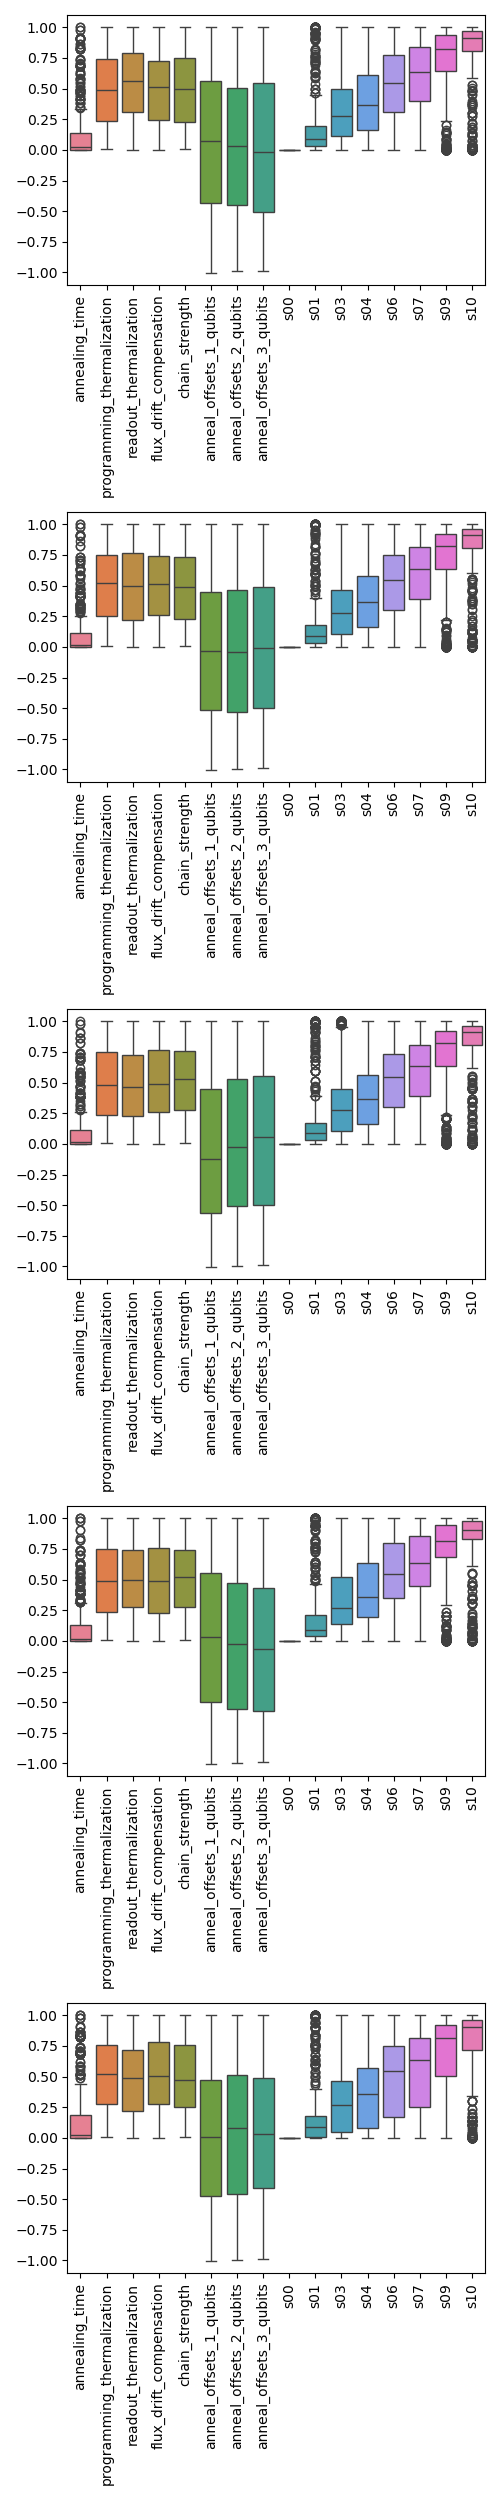

In [12]:
print(params)
fig, ax = plt.subplots(ncols=1, nrows=num_chunks, figsize=(5, num_chunks*5))
#fig, ax = plt.subplots(figsize=(5, 5))
for i in range(num_chunks):
    ax[i] = sns.boxplot(ax=ax[i], data = df_params_rescaled[params_to_scale].iloc[chunks[i]], order = params_to_scale, orient='v', whis=1.5)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    #set_xticklabels(params_to_scale, rotation=60)
fig. tight_layout()
fig.savefig(pathlib.Path('out',f'boxplots_params_rescaled_binned_by_fraction_samples_found_best_{num_chunks}bins_{chunks[0].shape[0]}binsize.svg'))
np.arange(5)